In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, \
                            roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with labels given by the clustering)

## Decision tree

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_clustering = pd.read_csv('datasets/clustering_labels.csv', index_col=0)
customer_clustering = customer_profile[['CustomerID', 'Delta','Median', 'RFrequency']].merge(customer_clustering[['CustomerID', 'Label']], on='CustomerID')
del customer_profile
customer_clustering

,CustomerID,Delta,Median,RFrequency,Label
0,12347,366,584.910,0.019126,High
1,12348,283,298.500,0.014134,Medium
2,12350,1,294.400,1.000000,Low
3,12352,261,226.250,0.026820,Medium
4,12353,1,89.000,1.000000,Low
...,...,...,...,...,...
3855,18280,1,180.600,1.000000,Low
3856,18281,1,80.820,1.000000,Low
3857,18282,119,89.025,0.016807,Medium
3858,18283,334,113.500,0.047904,Medium


In [3]:
df_majority = customer_clustering[customer_clustering.Label == 'Medium']
df_minority = customer_clustering[customer_clustering.Label == 'High']
df_middle   = customer_clustering[customer_clustering.Label == 'Low']

customer_clustering.Label.value_counts()

Medium    1698
Low       1250
High       912
Name: Label, dtype: int64

In [4]:
#'''
# Oversample minority classes.

df_minority_oversampled = resample(df_minority,
                                   replace=True,  # Sample with replacement.
                                   n_samples=len(df_majority))

df_middle_oversampled = resample(df_middle,
                                 replace=True,
                                 n_samples=len(df_majority))

# Combine majority class with oversampled minority classes.
df_oversampled = pd.concat([df_majority, df_minority_oversampled, df_middle_oversampled])
 
# Display new class counts.
customer_clustering = df_oversampled
customer_clustering.Label.value_counts()
#'''

High      1698
Low       1698
Medium    1698
Name: Label, dtype: int64

In [5]:
'''
# Undersampling.

df_majority_undersampled = resample(df_majority,
                                    replace=False,  # Sample without replacement.
                                    n_samples=len(df_minority))

df_middle_undersampled = resample(df_middle,
                                  replace=False,
                                  n_samples=len(df_minority))

df_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])

customer_clustering = df_undersampled
customer_clustering.Label.value_counts()
'''

'\n# Undersampling.\n\ndf_majority_undersampled = resample(df_majority,\n                                    replace=False,  # Sample without replacement.\n                                    n_samples=len(df_minority))\n\ndf_middle_undersampled = resample(df_middle,\n                                  replace=False,\n                                  n_samples=len(df_minority))\n\ndf_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])\n\ncustomer_clustering = df_undersampled\ncustomer_clustering.Label.value_counts()\n'

In [6]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [7]:
variables = ['Label']

# Discretize data, in this case only Label
customer_clustering = discretize_data(customer_clustering, variables)

# Drop the categorical variables since we don't need them anymore 
customer_clustering = customer_clustering[['Delta', 'Median', 'Label_num']]

label = customer_clustering.pop('Label_num')

scaler = StandardScaler()
customer_clustering = scaler.fit_transform(customer_clustering.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_clustering, label, stratify=label, test_size=0.3)

## Expected prediction

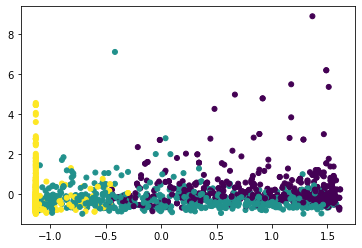

In [8]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)
plt.show()

## Decision Tree

In [9]:
# Decision tree

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12],
              "min_samples_split": sp_randint(20, 30),
              "min_samples_leaf": sp_randint(5, 30),
              "criterion": ["entropy", "gini"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()

grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist,
                                 n_iter=n_iter_search,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [10]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 23}


In [11]:
# Decision tree best setting parameters

dec_t = tree.DecisionTreeClassifier(**grid_search.best_params_).fit(train_set, train_label)

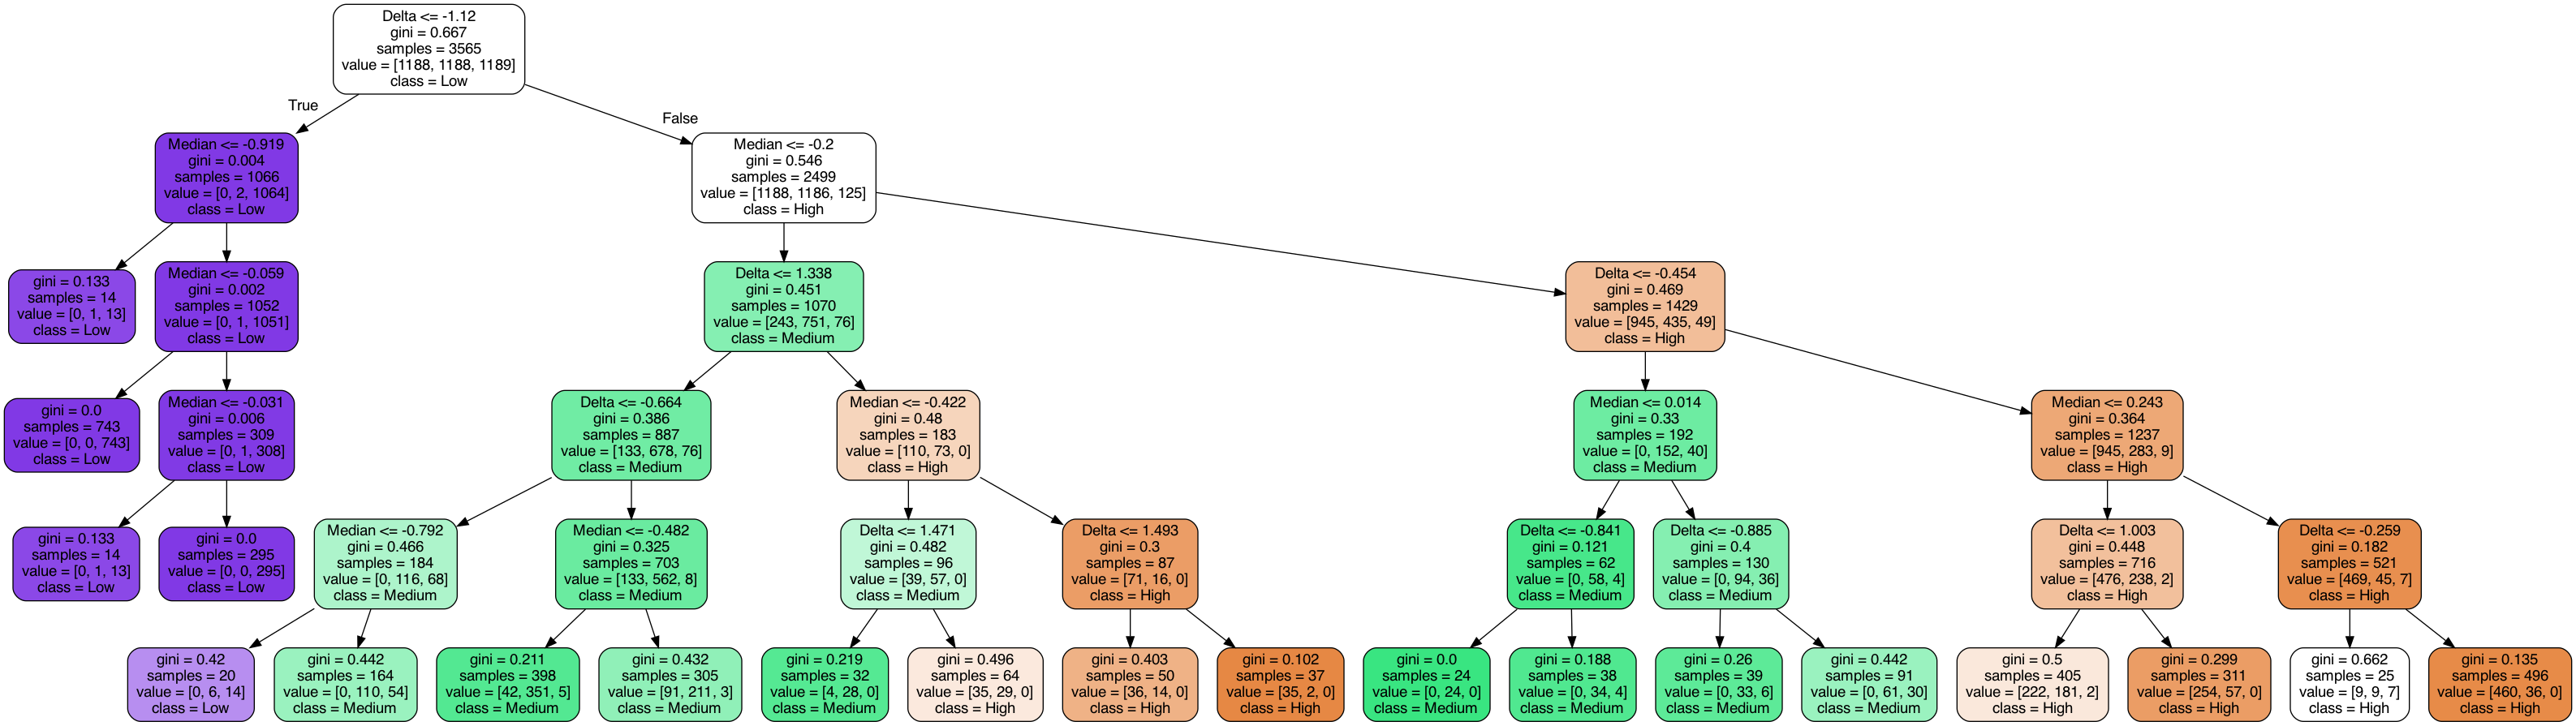

In [12]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Delta', 'Median'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [13]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [14]:
# Predict phase

train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [15]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [16]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8361851332398317
Accuracy test set:  0.8338783518639634

F1 score train set: 0.837158498830204
F1 score test set:  0.8350385658402414
Train:
              precision    recall  f1-score   support

        High       0.76      0.88      0.82      1188
      Medium       0.78      0.72      0.75      1188
         Low       0.99      0.91      0.95      1189

    accuracy                           0.84      3565
   macro avg       0.84      0.84      0.84      3565
weighted avg       0.84      0.84      0.84      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.76      0.87      0.82       510
      Medium       0.77      0.73      0.75       510
         Low       0.99      0.90      0.94       509

    accuracy                           0.83      1529
   macro avg       0.84      0.83      0.84      1529
weighted avg       0.84      0.83      0.84      1529



In [17]:
# Compute confusion matrix.

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1051  137    0]
 [ 328  852    8]
 [   9  102 1078]]
------------------
Test:
[[445  65   0]
 [134 370   6]
 [  3  46 460]]


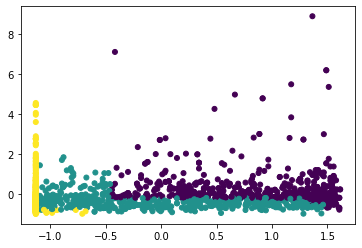

In [18]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)
plt.show()

## SVM

In [19]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale', 1e-2, 1e-3, 1e-4, 1e-5],
          'C'     : [0.001, 0.10, 0.1, 0.5, 1, 10]
         }

grid_search = RandomizedSearchCV(SVC(), params,
                                 n_jobs=-1,
                                 n_iter=n_iter_search,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

print(grid_search.best_params_)


# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(**grid_search.best_params_).fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

pd.concat([pd.DataFrame(grid_search.cv_results_["params"]), pd.DataFrame(grid_search.cv_results_["mean_test_score"],
                                                                         columns=["Accuracy"])], axis=1)

{'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


,kernel,gamma,C,Accuracy
0,poly,0.001,1.000,0.334642
1,sigmoid,0.001,0.100,0.528191
2,linear,scale,0.001,0.683029
3,linear,0.001,0.100,0.791585
4,poly,0.01,0.500,0.336325
5,sigmoid,1e-05,0.100,0.527910
6,sigmoid,0.001,0.500,0.598878
7,sigmoid,0.01,1.000,0.757924
8,rbf,0.01,0.100,0.705750
9,sigmoid,0.001,10.000,0.761290


In [20]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [21]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8244039270687237
Accuracy test set:  0.8129496402877698

F1 score train set: 0.8256419931141998
F1 score test set:  0.8137346851054685
Train:
              precision    recall  f1-score   support

        High       0.79      0.81      0.80      1188
      Medium       0.73      0.75      0.74      1188
         Low       0.96      0.92      0.94      1189

    accuracy                           0.82      3565
   macro avg       0.83      0.82      0.83      3565
weighted avg       0.83      0.82      0.83      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.79      0.80      0.79       510
      Medium       0.72      0.72      0.72       510
         Low       0.94      0.91      0.93       509

    accuracy                           0.81      1529
   macro avg       0.81      0.81      0.81      1529
weighted avg       0.81      0.81      0.81      1529



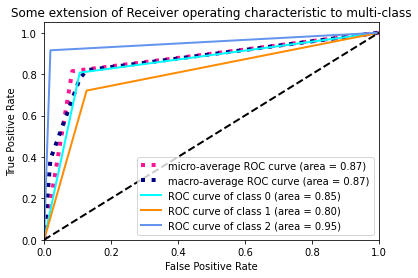

In [22]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

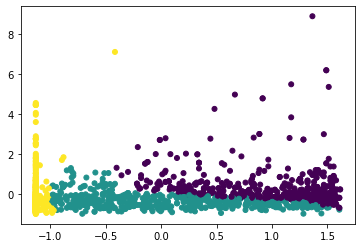

In [23]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_svm, s=25)
plt.show()

## KNN

In [24]:
params = {'n_neighbors': [2, 4, 6, 8, 10, 15, 20, 25, 50],
          'algorithm': ['ball_tree', 'kd_tree']
         }

grid_search = RandomizedSearchCV(KNeighborsClassifier(), params,
                                 n_jobs=-1,
                                 n_iter=n_iter_search,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

print(grid_search.best_params_)


knn = KNeighborsClassifier(**grid_search.best_params_).fit(train_set, train_label)

/usr/local/Cellar/python@3.8/3.8.6_2/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_neighbors': 2, 'algorithm': 'ball_tree'}


In [25]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [26]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.920617110799439
Accuracy test set:  0.8338783518639634

F1 score train set: 0.9199934264631567
F1 score test set:  0.8308093378655628
Train:
              precision    recall  f1-score   support

        High       0.83      1.00      0.91      1188
      Medium       0.96      0.80      0.87      1188
         Low       1.00      0.97      0.98      1189

    accuracy                           0.92      3565
   macro avg       0.93      0.92      0.92      3565
weighted avg       0.93      0.92      0.92      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.74      0.94      0.83       510
      Medium       0.82      0.64      0.72       510
         Low       0.97      0.93      0.95       509

    accuracy                           0.83      1529
   macro avg       0.84      0.83      0.83      1529
weighted avg       0.84      0.83      0.83      1529



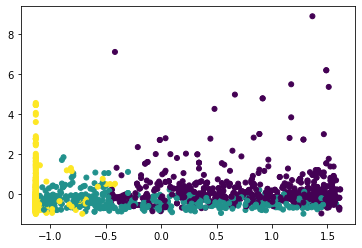

In [27]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_knn, s=25)
plt.show()

## Classification with Random Forest

In [28]:
# Define and fit a random forest.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1, len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2: 0.25}]}

n_iter_search = 50

rf = RandomForestClassifier()
grid_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                 n_iter=n_iter_search,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [29]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 14, 'min_samples_split': 21}


In [30]:
rf = RandomForestClassifier(**grid_search.best_params_).fit(train_set, train_label)

In [31]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [32]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8482468443197756
Accuracy test set:  0.8312622629169392

F1 score train set: 0.8495471433059096
F1 score test set:  0.833017419093559
Train:
              precision    recall  f1-score   support

        High       0.78      0.88      0.83      1188
      Medium       0.79      0.75      0.77      1188
         Low       0.99      0.91      0.95      1189

    accuracy                           0.85      3565
   macro avg       0.85      0.85      0.85      3565
weighted avg       0.85      0.85      0.85      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.77      0.85      0.81       510
      Medium       0.75      0.74      0.75       510
         Low       0.99      0.91      0.95       509

    accuracy                           0.83      1529
   macro avg       0.84      0.83      0.83      1529
weighted avg       0.84      0.83      0.83      1529



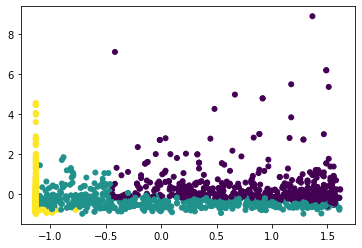

In [33]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_rf, s=25)
plt.show()

## Neural networks

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [36]:
history = model.fit(train_set, train_label_nn,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/50
10/10 [==============================] - 0s 26ms/step - loss: 1.0283 - accuracy: 0.5351 - val_loss: 0.9793 - val_accuracy: 0.6607
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 0.9727 - accuracy: 0.5711 - val_loss: 0.9377 - val_accuracy: 0.6785
Epoch 3/50
10/10 [==============================] - 0s 7ms/step - loss: 0.9477 - accuracy: 0.5872 - val_loss: 0.8939 - val_accuracy: 0.6860
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 0.9139 - accuracy: 0.6152 - val_loss: 0.8503 - val_accuracy: 0.6972
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 0.8637 - accuracy: 0.6365 - val_loss: 0.8084 - val_accuracy: 0.7103
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 0.8265 - accuracy: 0.6665 - val_loss: 0.7690 - val_accuracy: 0.7178
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.8048 - accuracy: 0.6509 - val_loss: 0.7350 - val_accuracy: 0.7243
Epoch 8/50
10/10 [=

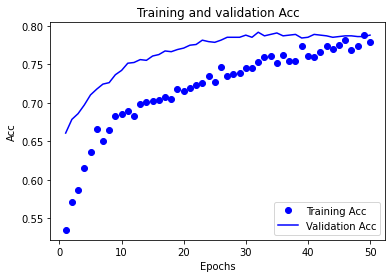

In [37]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [38]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [39]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7997194950911641
Accuracy test set:  0.7946370176586004

F1 score train set: 0.7951657564339482
F1 score test set:  0.79071354221424
Train:
              precision    recall  f1-score   support

        High       0.78      0.81      0.80      1188
      Medium       0.74      0.63      0.68      1188
         Low       0.86      0.95      0.91      1189

    accuracy                           0.80      3565
   macro avg       0.79      0.80      0.80      3565
weighted avg       0.79      0.80      0.80      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.79      0.80      0.79       510
      Medium       0.72      0.64      0.67       510
         Low       0.87      0.95      0.90       509

    accuracy                           0.79      1529
   macro avg       0.79      0.79      0.79      1529
weighted avg       0.79      0.79      0.79      1529



## Classification with Naive Bayes

In [40]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [41]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7671809256661991
Accuracy test set:  0.750163505559189

F1 score train set: 0.7657792035632347
F1 score test set:  0.7483304333421998
Train:
              precision    recall  f1-score   support

        High       0.75      0.71      0.73      1188
      Medium       0.65      0.65      0.65      1188
         Low       0.89      0.93      0.91      1189

    accuracy                           0.77      3565
   macro avg       0.76      0.77      0.77      3565
weighted avg       0.76      0.77      0.77      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.73      0.69      0.71       510
      Medium       0.63      0.62      0.62       510
         Low       0.89      0.94      0.91       509

    accuracy                           0.75      1529
   macro avg       0.75      0.75      0.75      1529
weighted avg       0.75      0.75      0.75      1529



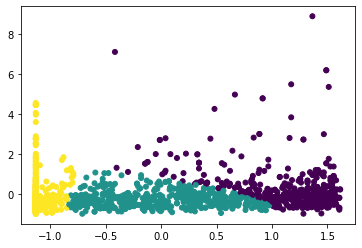

In [42]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_gnb, s=25)